In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

cuda


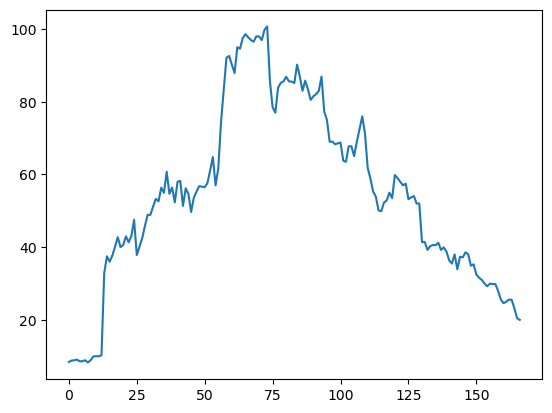

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
 
df = pd.read_csv('./data/AAMC 과거 데이터.csv')[['종가']].values.astype('float32')
 
plt.plot(df)
plt.show()

In [5]:
import torch
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [6]:
len(df)

167

In [7]:
lookback = 7
# train-test split for time series
train_size = int(len(df) * 0.67)
test_size = len(df) - train_size
train, test = df[:train_size], df[train_size:]
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([104, 7, 1]) torch.Size([104, 7, 1])
torch.Size([49, 7, 1]) torch.Size([49, 7, 1])


C:\Users\gkdud\AppData\Local\Temp\ipykernel_388920\2861746758.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(X), torch.tensor(y)


In [21]:
import torch.nn as nn
 
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        print(x.shape)
        x = self.linear(x)
        return x

In [22]:
model = Model()
model(torch.Tensor(8, 7, 1)).shape

torch.Size([8, 7, 50])


torch.Size([8, 7, 1])

In [9]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = Model()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 67.1677, test RMSE 41.0741
Epoch 100: train RMSE 22.9551, test RMSE 6.5610
Epoch 200: train RMSE 9.9861, test RMSE 8.2397
Epoch 300: train RMSE 6.3643, test RMSE 7.9863
Epoch 400: train RMSE 5.0787, test RMSE 7.1997
Epoch 500: train RMSE 4.2587, test RMSE 7.1213
Epoch 600: train RMSE 3.8003, test RMSE 7.2586
Epoch 700: train RMSE 3.5640, test RMSE 6.9597
Epoch 800: train RMSE 3.6060, test RMSE 7.1402
Epoch 900: train RMSE 3.3680, test RMSE 7.1987
Epoch 1000: train RMSE 3.5766, test RMSE 7.3796
Epoch 1100: train RMSE 3.2843, test RMSE 6.8957
Epoch 1200: train RMSE 3.2552, test RMSE 6.9283
Epoch 1300: train RMSE 3.5154, test RMSE 7.3776
Epoch 1400: train RMSE 3.2190, test RMSE 7.2009
Epoch 1500: train RMSE 3.2254, test RMSE 6.9342
Epoch 1600: train RMSE 3.1510, test RMSE 7.1449
Epoch 1700: train RMSE 3.1463, test RMSE 6.9087
Epoch 1800: train RMSE 3.0904, test RMSE 6.9088
Epoch 1900: train RMSE 3.0715, test RMSE 6.9302


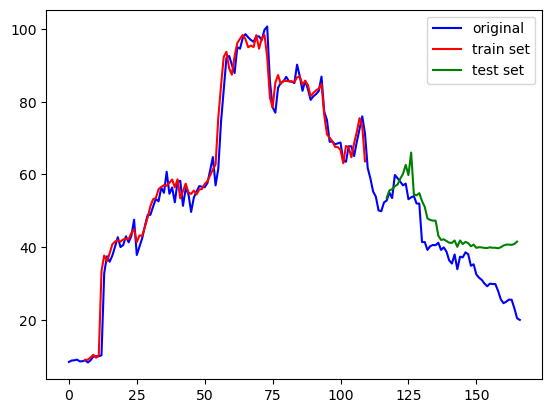

In [10]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(df) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(df) * np.nan
    test_plot[train_size+lookback:len(df)] = model(X_test)[:, -1, :]
# plot
plt.plot(df, c='b', label='original')
plt.plot(train_plot[1:], c='r', label='train set')
plt.plot(test_plot[1:], c='g', label='test set')
plt.legend()
plt.show()

In [26]:
import torch.nn as nn
 
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(7, 50)
        self.linear2 = nn.Linear(50, 1)
    def forward(self, x):
        x = nn.ReLU()(self.linear1(x))
        x = self.linear2(x)
        return x

In [28]:
model = Model()
model(torch.Tensor(8, 7)).shape

torch.Size([8, 1])

In [37]:
import torch
 
def create_dataset2(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X).squeeze(), torch.tensor(y).squeeze(-1)

In [38]:
lookback = 7
# train-test split for time series
train_size = int(len(df) * 0.67)
test_size = len(df) - train_size
train, test = df[:train_size], df[train_size:]
X_train, y_train = create_dataset2(train, lookback=lookback)
X_test, y_test = create_dataset2(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([104, 7]) torch.Size([104, 1])
torch.Size([49, 7]) torch.Size([49, 1])


In [39]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = Model()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 62.7022, test RMSE 36.8799
Epoch 100: train RMSE 5.1525, test RMSE 2.7754
Epoch 200: train RMSE 4.8670, test RMSE 2.9050
Epoch 300: train RMSE 4.8046, test RMSE 3.3173
Epoch 400: train RMSE 4.5772, test RMSE 3.2955
Epoch 500: train RMSE 4.7632, test RMSE 2.5357
Epoch 600: train RMSE 4.3653, test RMSE 3.0413
Epoch 700: train RMSE 4.5689, test RMSE 2.7069
Epoch 800: train RMSE 4.6078, test RMSE 3.8349
Epoch 900: train RMSE 4.4005, test RMSE 2.9332
Epoch 1000: train RMSE 4.3063, test RMSE 3.2065
Epoch 1100: train RMSE 4.3059, test RMSE 3.0926
Epoch 1200: train RMSE 4.2950, test RMSE 3.4217
Epoch 1300: train RMSE 4.2859, test RMSE 3.0741
Epoch 1400: train RMSE 4.9279, test RMSE 4.4059
Epoch 1500: train RMSE 4.2983, test RMSE 2.9873
Epoch 1600: train RMSE 4.3207, test RMSE 3.6900
Epoch 1700: train RMSE 4.3005, test RMSE 3.5737
Epoch 1800: train RMSE 4.2459, test RMSE 3.5855
Epoch 1900: train RMSE 4.1604, test RMSE 3.4181


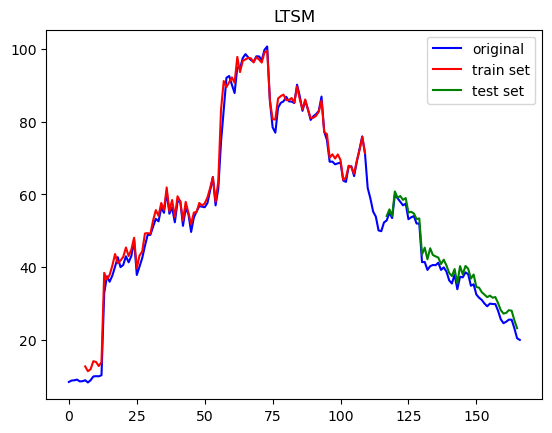

In [45]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(df) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1]
    train_plot[lookback:train_size] = model(X_train)
    # shift test predictions for plotting
    test_plot = np.ones_like(df) * np.nan
    test_plot[train_size+lookback:len(df)] = model(X_test)
# plot
plt.plot(df, c='b', label='original')
plt.plot(train_plot[1:], c='r', label='train set')
plt.plot(test_plot[1:], c='g', label='test set')
plt.legend()
plt.title('LTSM')
plt.show()